In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/projects/sage/sage-6.10/local/lib/python2.7/site-packages/matplotlib-1.5.0-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Fluctuation analysis for fixed-levels algorithm
In this section we will do some analysis of the comportment of $\sqrt N\frac{\hat p - p}{p}$. In the idealized situation, by the thm of CTL, it converges to a normal law and we are interested in estimating the variance of this normal distribution.

In [2]:
from numba import autojit
@autojit
def S(X):
    '''score function which is a black box'''
    return np.abs(X)

## Calculate the idealized levels

In [3]:
from scipy.stats import norm

# sequence of levels: idealized situation 

q_test = 8
p = (1-norm.cdf(q_test))*2

###idealized situation
p_0 = 0.75 #success rate
n_0 = int(np.floor(np.log(p)/np.log(p_0)))
r = p/(p_0**n_0)
sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0 + (1-r)/r)
#sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0)
print ("p_0 = " + str(p_0) + '\t n_0 =' + str(n_0) + "\t r = " + str(r))

L = [-np.Inf]
for k in range(1,n_0+1,1):
    L = np.append(L, norm.ppf(1 - p_0**k/2))
L_ideal = np.append(L, q_test)
num_lev = len(L_ideal)

##var_relative

print ("sequence of levels: "+ str(L_ideal))
print ("num_lev: "+ str(num_lev))
print ("level interested, L = "+ str(q_test))
# real value of p
print ("real value of p:" + str(p))
print ("theoretical relative deviation: " + str(sigma_theoretical))
#print ("tested, no bug")


p_0 = 0.75	 n_0 =119	 r = 0.982428906034
sequence of levels: [       -inf  0.31863936  0.57913216  0.80317257  1.00187028  1.18175057
  1.34700533  1.50050404  1.64430646  1.77994669  1.90860153  2.0311958
  2.14847107  2.26103219  2.36937975  2.47393339  2.57504876  2.67303027
  2.76814076  2.86060894  2.95063523  3.03839637  3.12404913  3.20773329
  3.28957411  3.36968431  3.44816574  3.5251108   3.60060362  3.67472101
  3.74753336  3.81910533  3.88949648  3.95876183  4.0269523   4.09411515
  4.16029431  4.22553071  4.28986255  4.35332555  4.41595318  4.47777683
  4.53882599  4.59912843  4.65871029  4.71759627  4.77580968  4.83337259
  4.89030588  4.94662936  5.00236184  5.05752119  5.1121244   5.16618764
  5.21972633  5.27275518  5.32528822  5.37733886  5.42891993  5.48004368
  5.53072188  5.58096577  5.63078615  5.68019339  5.72919743  5.77780783
  5.82603379  5.87388413  5.92136737  5.96849171  6.01526505  6.061695
  6.10778891  6.15355384  6.19899673  6.24412402  6.28894226  6.33

## Algorithm (fixed_levels)

In [15]:
def mu_0_test(N):
    '''The distribution of X that we could simulate'''
    return np.random.normal(0,1,N)



#tuning parameter for shaker
####Attention !!!!!!!!   we could not choose a very large sigma_1 !!!

def shaker_test(X,sigma_1):
    c = np.sqrt(1+sigma_1**2)
    return np.random.normal(X/c,sigma_1/c,1)
    \

def simulation_fixed_levels(real_p, N , L, score_function, mu_0, shaker, reject_rate = 0.3, sigma_default = 0.5,
                            descent_step = 0.02, shake_times = 5, status_tracking = False):

    
    num_lev = len(L) 
    
    list_p_hat = []
    index_finish = False ###### to ensure that I_k won't be empty
    while(index_finish == False):
        X= mu_0(N)
        for k in range(num_lev - 1):


        ###### construction of I_k 
            I = [X[j] for j in range(N) if score_function(X[j])>L[k+1]]
            ell = len(I)
            if ell == 0: 
                break



        ###### estimation of p_k
            list_p_hat = np.append(list_p_hat, ell/np.float(N))

        ###### start of transition
            X[0:ell] = I
        ###### permutation trick
            if ell != N:

                I = np.random.permutation(I)
                for j in range(ell,N,1):
                    X[j] = I[j%ell]
            ###### we only accept the transition in A_{k+1} / shaker

            ###### we conduct an adaptive method to choose the sigma_1 for shaker 
            ###### by controling the reject_rate of the transition in A_{k+1}

                for index_shaker in range(shake_times):
                    rate = 1.
                    sigma_1 = sigma_default
                    while(rate>reject_rate):

                        reject = N - ell
                        for j in range(ell,N,1):  #if we don't change the elements of I_k
                        #for j in range(N):       #if we change the elements of I_k to have less dependence

                            X_iter = shaker(X[j],sigma_1 = sigma_1)
                            if score_function(X_iter) > L[k+1]:
                                X[j] = X_iter
                                reject -= 1.
                        rate = reject/np.float(N - ell)
                        #rate = reject/np.float(N)

                        sigma_1 -= descent_step
                        if sigma_1 <= 0:
                            break


                    
    ###### 
        index_finish = True
                
    ###### end of transition

    ###### estimation of p
    p_hat = np.prod(list_p_hat)
    ###### relative variation
    rel_var = (p_hat - real_p)/real_p
    ###### tracking status
    if status_tracking == True:
        print ("levels: " + str(L))
        print ("real value of p:" + str(real_p))
        print ("estimation of p: " + str(p_hat))
        print ("sqrt(N) * relative variation: " + str(rel_var*np.sqrt(N)))
        print ("N: " + str(N))
    
    
    return p_hat, rel_var



In [14]:
#test
from time import time
t_0 = time()
simulation_fixed_levels(real_p = p ,N = 100, L = L_ideal, descent_step = 0.1,shake_times = 3
                        , score_function = S , mu_0 = mu_0_test, shaker = shaker_test, status_tracking = True)
print ("Time spent :"+ str(time() - t_0)+"s")

levels: [       -inf  0.31863936  0.57913216  0.80317257  1.00187028  1.18175057
  1.34700533  1.50050404  1.64430646  1.77994669  1.90860153  2.0311958
  2.14847107  2.26103219  2.36937975  2.47393339  2.57504876  2.67303027
  2.76814076  2.86060894  2.95063523  3.03839637  3.12404913  3.20773329
  3.28957411  3.36968431  3.44816574  3.5251108   3.60060362  3.67472101
  3.74753336  3.81910533  3.88949648  3.95876183  4.0269523   4.09411515
  4.16029431  4.22553071  4.28986255  4.35332555  4.41595318  4.47777683
  4.53882599  4.59912843  4.65871029  4.71759627  4.77580968  4.83337259
  4.89030588  4.94662936  5.00236184  5.05752119  5.1121244   5.16618764
  5.21972633  5.27275518  5.32528822  5.37733886  5.42891993  5.48004368
  5.53072188  5.58096577  5.63078615  5.68019339  5.72919743  5.77780783
  5.82603379  5.87388413  5.92136737  5.96849171  6.01526505  6.061695
  6.10778891  6.15355384  6.19899673  6.24412402  6.28894226  6.33345765
  6.37767607  6.42160316  6.46524491  6.508606

In [16]:
list_N = [100,500,1000]
n_choice_N = len(list_N)
n_sim = 100
t_0 = time()
sim_N =[[ [] for j in range(n_sim)] for i in range(n_choice_N)]
print ("Total number of simulation: " + str(n_choice_N))
for index_sim in range(n_choice_N):
    for i in range(n_sim):
        
        sim_N[index_sim][i] = simulation_fixed_levels(real_p = p, N = list_N[index_sim], L = L_ideal
                        , score_function = S , mu_0 = mu_0_test, shaker = shaker_test, descent_step = 0.1)
    print ("simulation completed: " + str(index_sim+1))
sim_N = np.array(sim_N)
print ("Time spent :"+ str(time() - t_0)+"s")

Total number of simulation: 3
simulation completed: 1
simulation completed: 2
simulation completed: 3
Time spent :1293.97268295s


In [17]:
estimation_sim = np.array([sim_N[i][:,0] for i in range(n_choice_N)])
sigma_relative_variation_sim = np.array([sim_N[i][:,1] * np.sqrt(list_N[i]) for i in range(n_choice_N)]) 
print ("theoretical relative deviation: " + str(sigma_theoretical))
std_sqrtN = np.array([np.std(sigma_relative_variation_sim[i]) for i in range(n_choice_N)])
print ("\sqrt N * std of relative deviation : " + str(std_sqrtN ))

theoretical relative deviation: 6.29956760627
\sqrt N * std of relative deviation : [ 11.23970427   6.16310993   6.62698786]


## Fluctuation

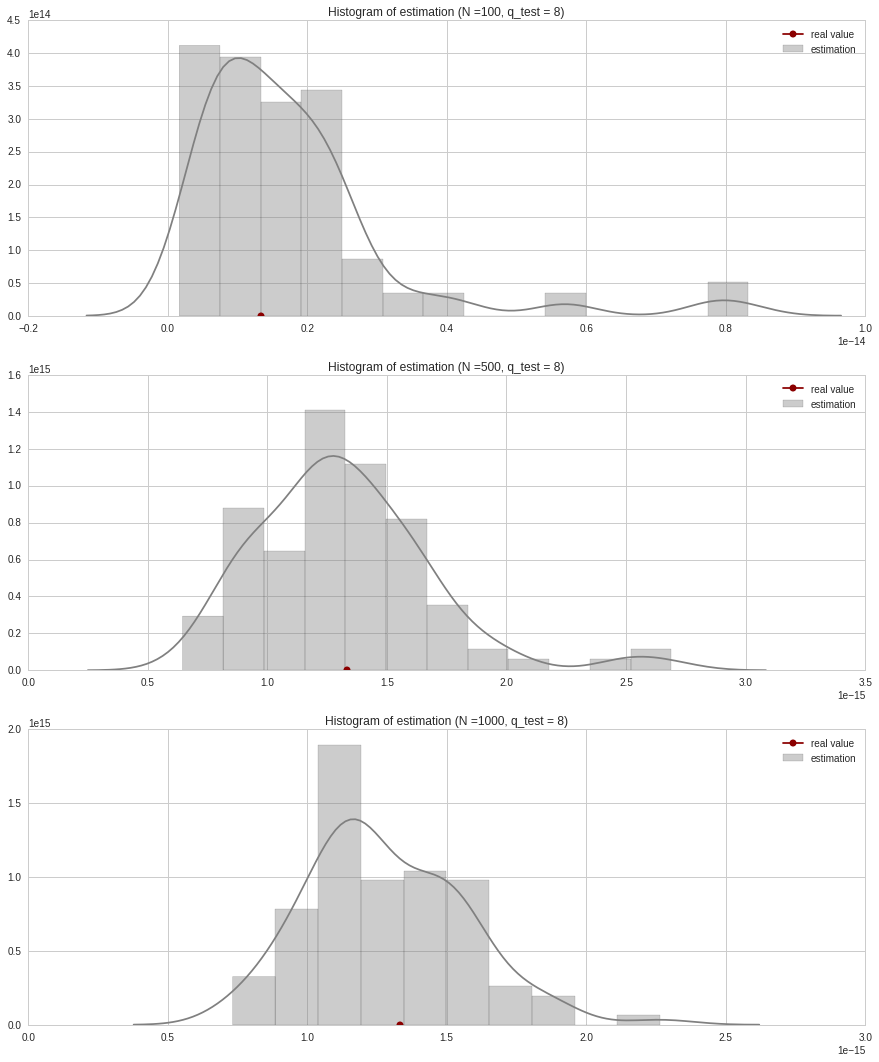

In [18]:
##fluctuation
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(estimation_sim[i], label = "estimation",color = "grey")
    plt.title('Histogram of estimation (N ='+str(list_N[i])+', q_test = 8)')
    x = np.arange(-15,15,0.1)
    plt.plot(p,0,marker = "o",color = 'darkred',label = "real value")
    plt.legend()
    #plt.xlim([-2e-15,2e-15])


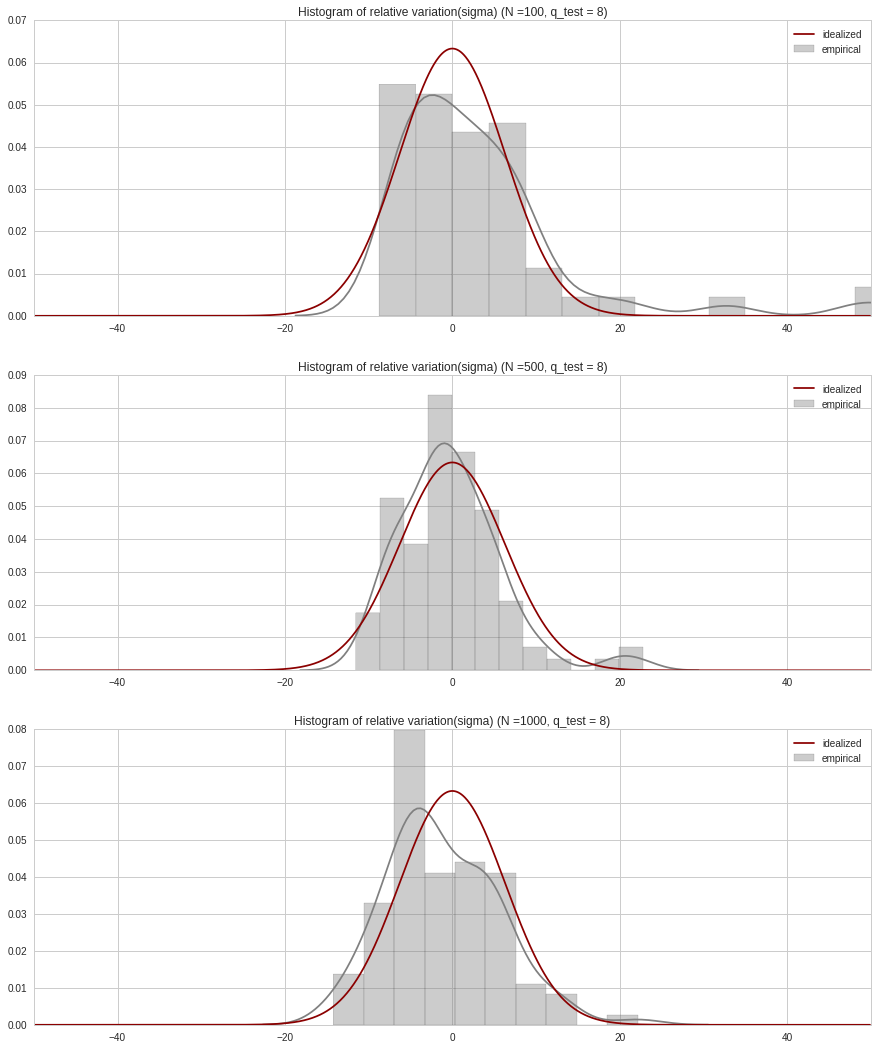

In [19]:
##fluctuation of variance(sigma)
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(sigma_relative_variation_sim[i] , label = "empirical",color = "grey")
    plt.title('Histogram of relative variation(sigma) (N ='+str(list_N[i])+', q_test = 8)')
    x = np.arange(-50,50,0.1)
    plt.plot(x,norm.pdf(x,0,sigma_theoretical), label = "idealized", color = "darkred")
    plt.legend()
    plt.xlim([-50,50])



(0, 1150)

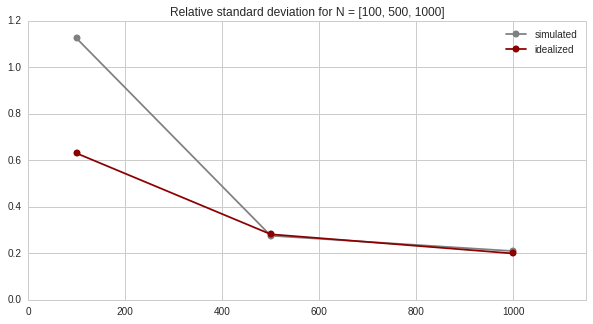

In [20]:
plt.figure(figsize = [10,5])
plt.plot(list_N, std_sqrtN/ np.sqrt(list_N), label = "simulated", marker = 'o',color ="grey")
plt.plot(list_N,  sigma_theoretical /np.sqrt(list_N), label = "idealized", marker = 'o' ,color = "darkred"   ) 
plt.legend()

plt.title("Relative standard deviation for N = "+str(list_N))
plt.xlim([0,1150])

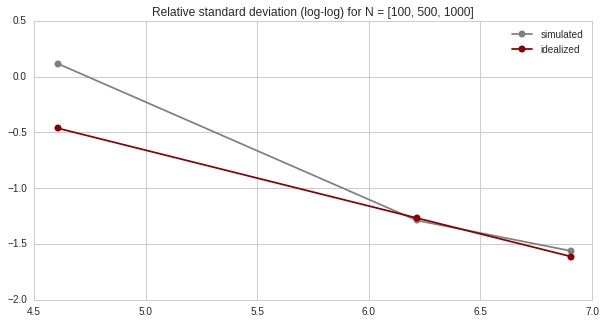

In [21]:
plt.figure(figsize = [10,5])
plt.plot(np.log(list_N), np.log(std_sqrtN/ np.sqrt(list_N)), label = "simulated", marker = 'o',color ="grey")
plt.plot(np.log(list_N),  np.log(sigma_theoretical /np.sqrt(list_N)), label = "idealized", marker = 'o' ,color ="darkred"   ) 
plt.legend()
plt.title("Relative standard deviation (log-log) for N = "+str(list_N))
